<a href="https://colab.research.google.com/github/Namratha0506/CHORNIC-KIDNEY-DISEASES-PROJECT-/blob/main/random_forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, accuracy_score, roc_curve, auc
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from sklearn.ensemble import StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

# LOAD AND PREPROCESSING CKD DATASET

In [ ]:
# Load the dataset
CKD_data = pd.read_csv("/content/drive/MyDrive/Namratha /Dataset .csv")  # Replace with your dataset path

# Display dataset information
print("Dataset Info:")
print(CKD_data.info())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 25 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     391 non-null    float64
 1   bp      388 non-null    float64
 2   sg      353 non-null    float64
 3   al      354 non-null    float64
 4   su      351 non-null    float64
 5   rbc     248 non-null    object 
 6   pc      335 non-null    object 
 7   pcc     396 non-null    object 
 8   ba      396 non-null    object 
 9   bgr     356 non-null    float64
 10  bu      381 non-null    float64
 11  sc      383 non-null    float64
 12  sod     313 non-null    float64
 13  pot     312 non-null    float64
 14  hemo    348 non-null    float64
 15  pcv     329 non-null    float64
 16  wbcc    294 non-null    float64
 17  rbcc    269 non-null    float64
 18  htn     398 non-null    object 
 19  dm      398 non-null    object 
 20  cad     398 non-null    object 
 21  appet   399 non-null    o

In [ ]:
# Check unique values in 'class' column
print("Unique values in 'class':", CKD_data['class'].unique())

# Standardize class values: lowercase and strip whitespace
CKD_data['class'] = CKD_data['class'].str.strip().str.lower()

# Map 'ckd' to 0 and 'notckd' to 1
CKD_data['class'] = CKD_data['class'].map({'ckd': 0, 'notckd': 1})

Unique values in 'class': ['ckd' 'ckd\t' 'notckd']


In [ ]:
# Check for NaN after mapping
if CKD_data['class'].isnull().any():
    print("\nRows with NaN in 'class' column after mapping:")
    print(CKD_data[CKD_data['class'].isnull()])

    # Handle NaN values (optional: drop or replace)
    # Example: Replace NaN with the most frequent class (0 or 1)
    most_frequent_class = CKD_data['class'].mode()[0]
    CKD_data['class'].fillna(most_frequent_class, inplace=True)

In [ ]:
CKD_data['class']

,class
0,0
1,0
2,0
3,0
4,0
...,...
395,1
396,1
397,1
398,1


In [ ]:
# categorical_cols = ['rbc', 'pc', 'pcc', 'ba', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane', 'class']
categorical_cols = ['rbc', 'pc', 'pcc', 'ba', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane']
label_encoder = LabelEncoder()

for col in categorical_cols:
    CKD_data[col] = label_encoder.fit_transform(CKD_data[col])


In [ ]:
CKD_data

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
0,48.0,80.0,1.020,1.0,0.0,2,1,0,0,121.0,...,44.0,7800.0,5.2,1,2,0,0,0,0,0
1,7.0,50.0,1.020,4.0,0.0,2,1,0,0,NaN,...,38.0,6000.0,NaN,0,1,0,0,0,0,0
2,62.0,80.0,1.010,2.0,3.0,1,1,0,0,423.0,...,31.0,7500.0,NaN,0,2,0,1,0,1,0
3,48.0,70.0,1.005,4.0,0.0,1,0,1,0,117.0,...,32.0,6700.0,3.9,1,1,0,1,1,1,0
4,51.0,80.0,1.010,2.0,0.0,1,1,0,0,106.0,...,35.0,7300.0,4.6,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,55.0,80.0,1.020,0.0,0.0,1,1,0,0,140.0,...,47.0,6700.0,4.9,0,1,0,0,0,0,1
396,42.0,70.0,1.025,0.0,0.0,1,1,0,0,75.0,...,54.0,7800.0,6.2,0,1,0,0,0,0,1
397,12.0,80.0,1.020,0.0,0.0,1,1,0,0,100.0,...,49.0,6600.0,5.4,0,1,0,0,0,0,1
398,17.0,60.0,1.025,0.0,0.0,1,1,0,0,114.0,...,51.0,7200.0,5.9,0,1,0,0,0,0,1


In [ ]:
CKD_data.fillna(CKD_data.mean(), inplace=True)


In [ ]:
CKD_data

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
0,48.0,80.0,1.020,1.0,0.0,2,1,0,0,121.000000,...,44.0,7800.0,5.200000,1,2,0,0,0,0,0
1,7.0,50.0,1.020,4.0,0.0,2,1,0,0,148.036517,...,38.0,6000.0,4.707435,0,1,0,0,0,0,0
2,62.0,80.0,1.010,2.0,3.0,1,1,0,0,423.000000,...,31.0,7500.0,4.707435,0,2,0,1,0,1,0
3,48.0,70.0,1.005,4.0,0.0,1,0,1,0,117.000000,...,32.0,6700.0,3.900000,1,1,0,1,1,1,0
4,51.0,80.0,1.010,2.0,0.0,1,1,0,0,106.000000,...,35.0,7300.0,4.600000,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,55.0,80.0,1.020,0.0,0.0,1,1,0,0,140.000000,...,47.0,6700.0,4.900000,0,1,0,0,0,0,1
396,42.0,70.0,1.025,0.0,0.0,1,1,0,0,75.000000,...,54.0,7800.0,6.200000,0,1,0,0,0,0,1
397,12.0,80.0,1.020,0.0,0.0,1,1,0,0,100.000000,...,49.0,6600.0,5.400000,0,1,0,0,0,0,1
398,17.0,60.0,1.025,0.0,0.0,1,1,0,0,114.000000,...,51.0,7200.0,5.900000,0,1,0,0,0,0,1


In [ ]:
CKD_data['rbc']

,rbc
0,2
1,2
2,1
3,1
4,1
...,...
395,1
396,1
397,1
398,1


In [ ]:
# Check for missing values in the dataset
missing_values = CKD_data.isnull().sum()

In [ ]:
missing_values

,0
age,0
bp,0
sg,0
al,0
su,0
rbc,0
pc,0
pcc,0
ba,0
bgr,0


In [ ]:
# Display columns with missing values and their counts
print("Missing values in each column:")
print(missing_values)

Missing values in each column:
age      0
bp       0
sg       0
al       0
su       0
rbc      0
pc       0
pcc      0
ba       0
bgr      0
bu       0
sc       0
sod      0
pot      0
hemo     0
pcv      0
wbcc     0
rbcc     0
htn      0
dm       0
cad      0
appet    0
pe       0
ane      0
class    0
dtype: int64


In [ ]:
# Optionally, display only columns with missing values
print("\nColumns with missing values:")
print(missing_values[missing_values > 0])


Columns with missing values:
Series([], dtype: int64)


# EDA

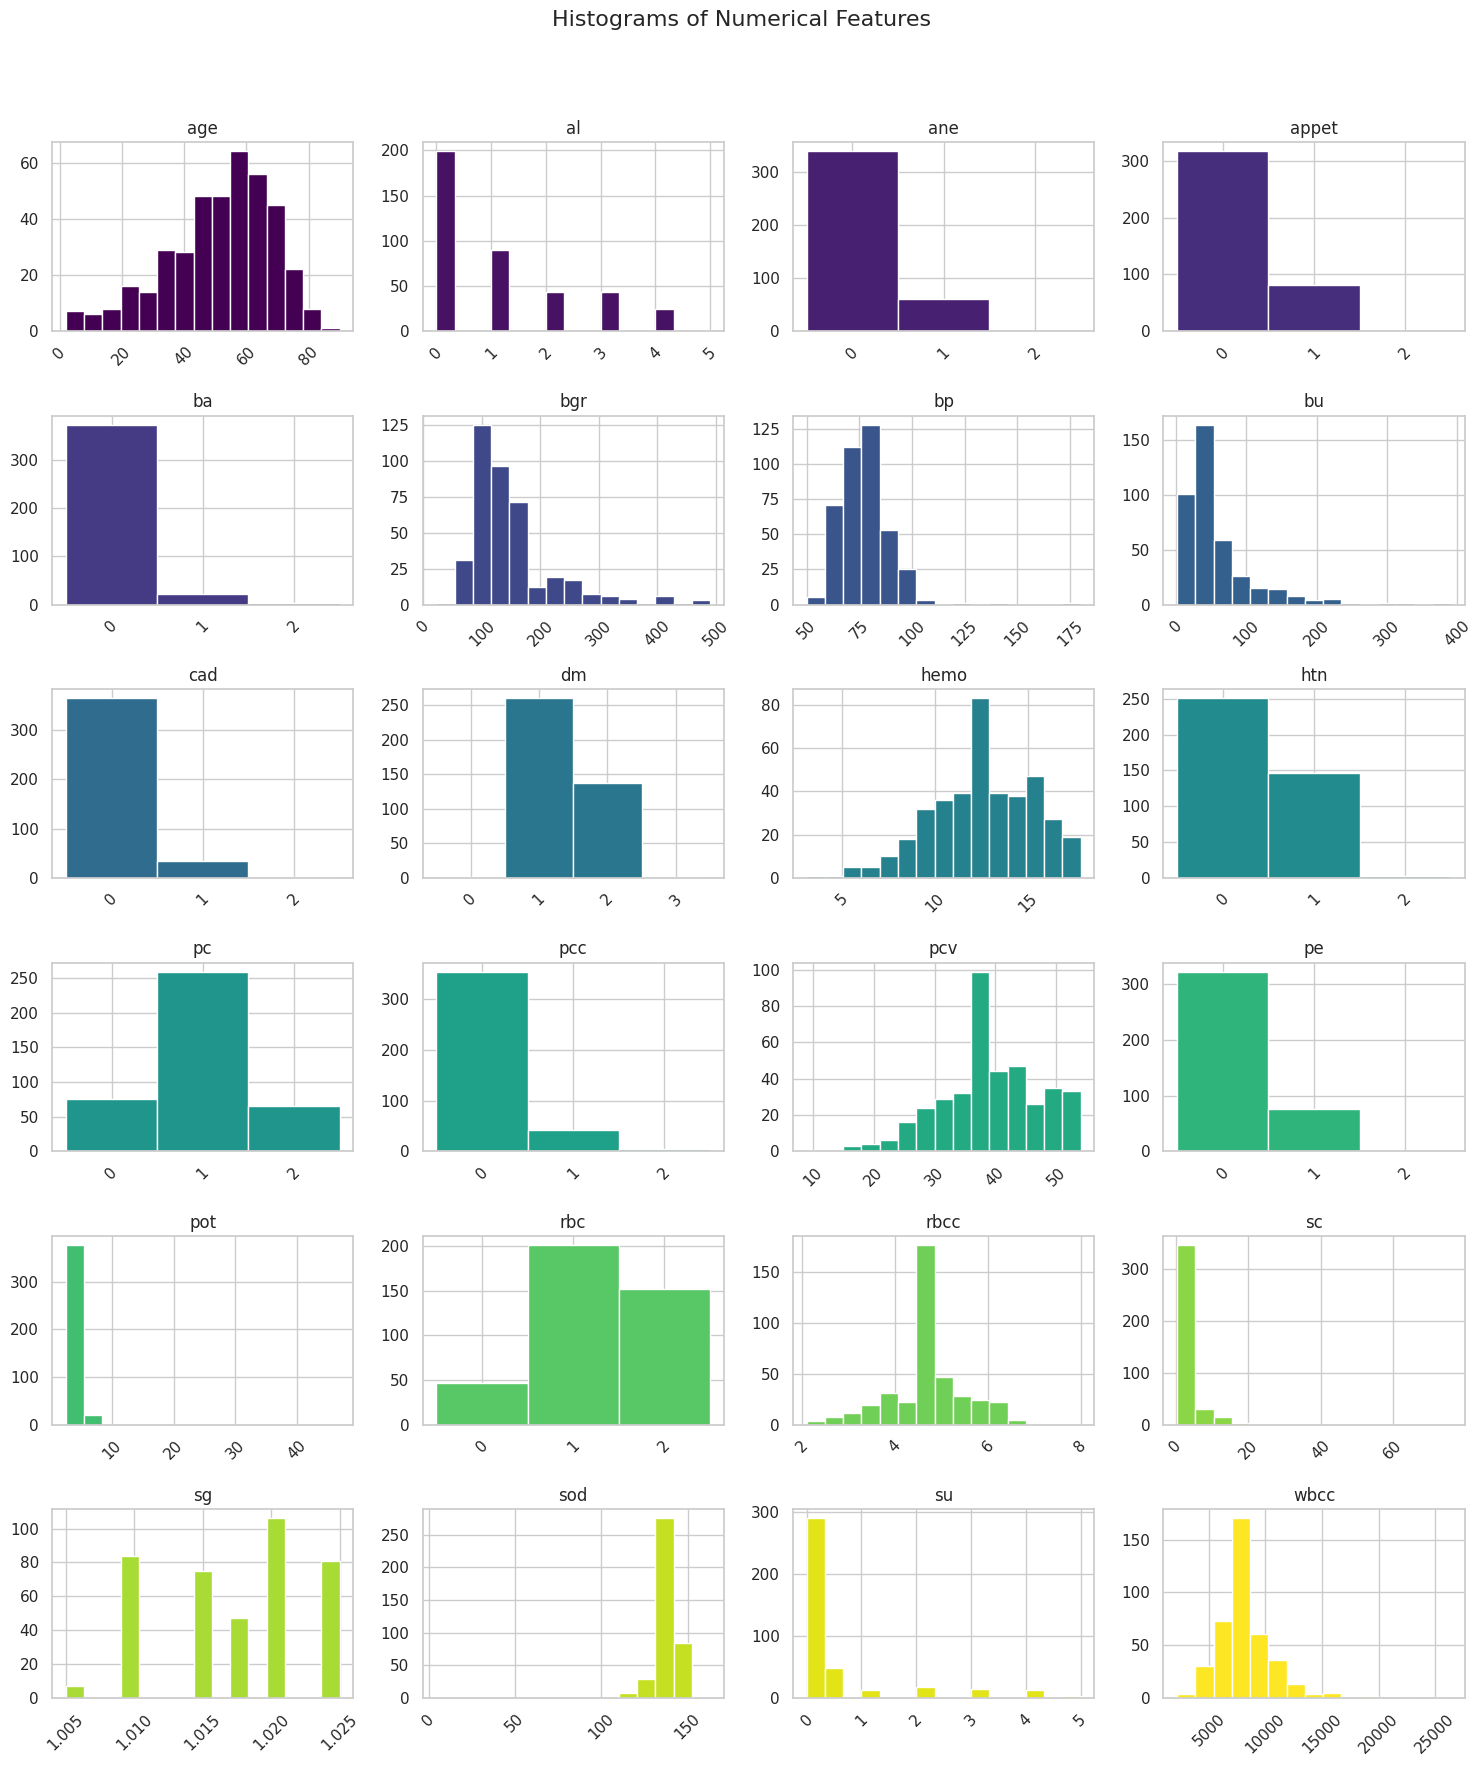

In [ ]:
sns.set(style="whitegrid")

numerical_cols = CKD_data.select_dtypes(include=np.number).columns.difference(['class'])

integer_ticks_cols = ['ane','appet', 'ba', 'cad', 'dm', 'htn', 'pc', 'pcc', 'pe', 'rbc']

# Calculating the number of rows and columns for the subplot grid
n_cols = 4
n_rows = (len(numerical_cols) + n_cols - 1) // n_cols

# Displaying histograms for numerical features to understand distributions
plt.figure(figsize=(15, 3 * n_rows))
for i, col in enumerate(numerical_cols):
    plt.subplot(n_rows, n_cols, i + 1)
    data = CKD_data[col].dropna()
    # Determine bin edges so that they are centered around integers if required
    if col in integer_ticks_cols:
        bins = np.arange(data.min() - 0.5, data.max() + 1.5, 1)  # Create bins centered on integers
    else:
        bins = 15  # Default number of bins for other columns

    plt.hist(data, bins=bins, color=plt.cm.viridis(np.linspace(0, 1, len(numerical_cols)))[i])
    plt.title(col)
    # Adjust ticks for columns that should display only integers
    if col in integer_ticks_cols:
        plt.xticks(np.arange(data.min(), data.max() + 1))  # Set x-ticks to integer values within the data range

    plt.xticks(rotation=45)
plt.suptitle('Histograms of Numerical Features', size=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


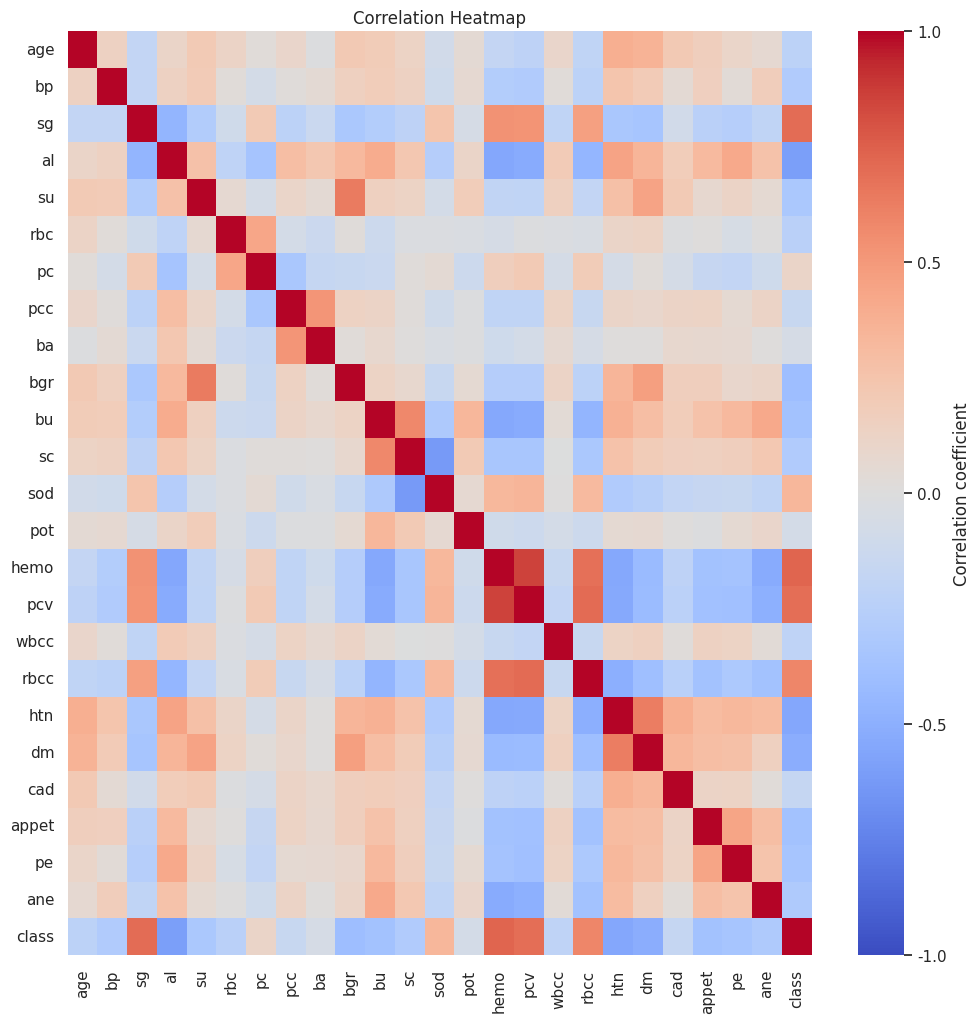

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Correlation matrix to understand relationships between metrics
plt.figure(figsize=(12, 12))
correlation_matrix = CKD_data.corr()
# Creating a heatmap without annotations and with the color bar properly centered at 0
ax = sns.heatmap(correlation_matrix, annot=None, cmap='coolwarm', center=0, vmin=-1, vmax=1)
plt.title('Correlation Heatmap')

# Adjust the y-axis labels
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, verticalalignment='center')

# Adjust colorbar
cbar = ax.collections[0].colorbar
cbar.set_label('Correlation coefficient')
cbar.set_ticks([-1, -0.5, 0, 0.5, 1])
cbar.set_ticklabels(['-1.0', '-0.5', '0.0', '0.5', '1.0'])

plt.show()


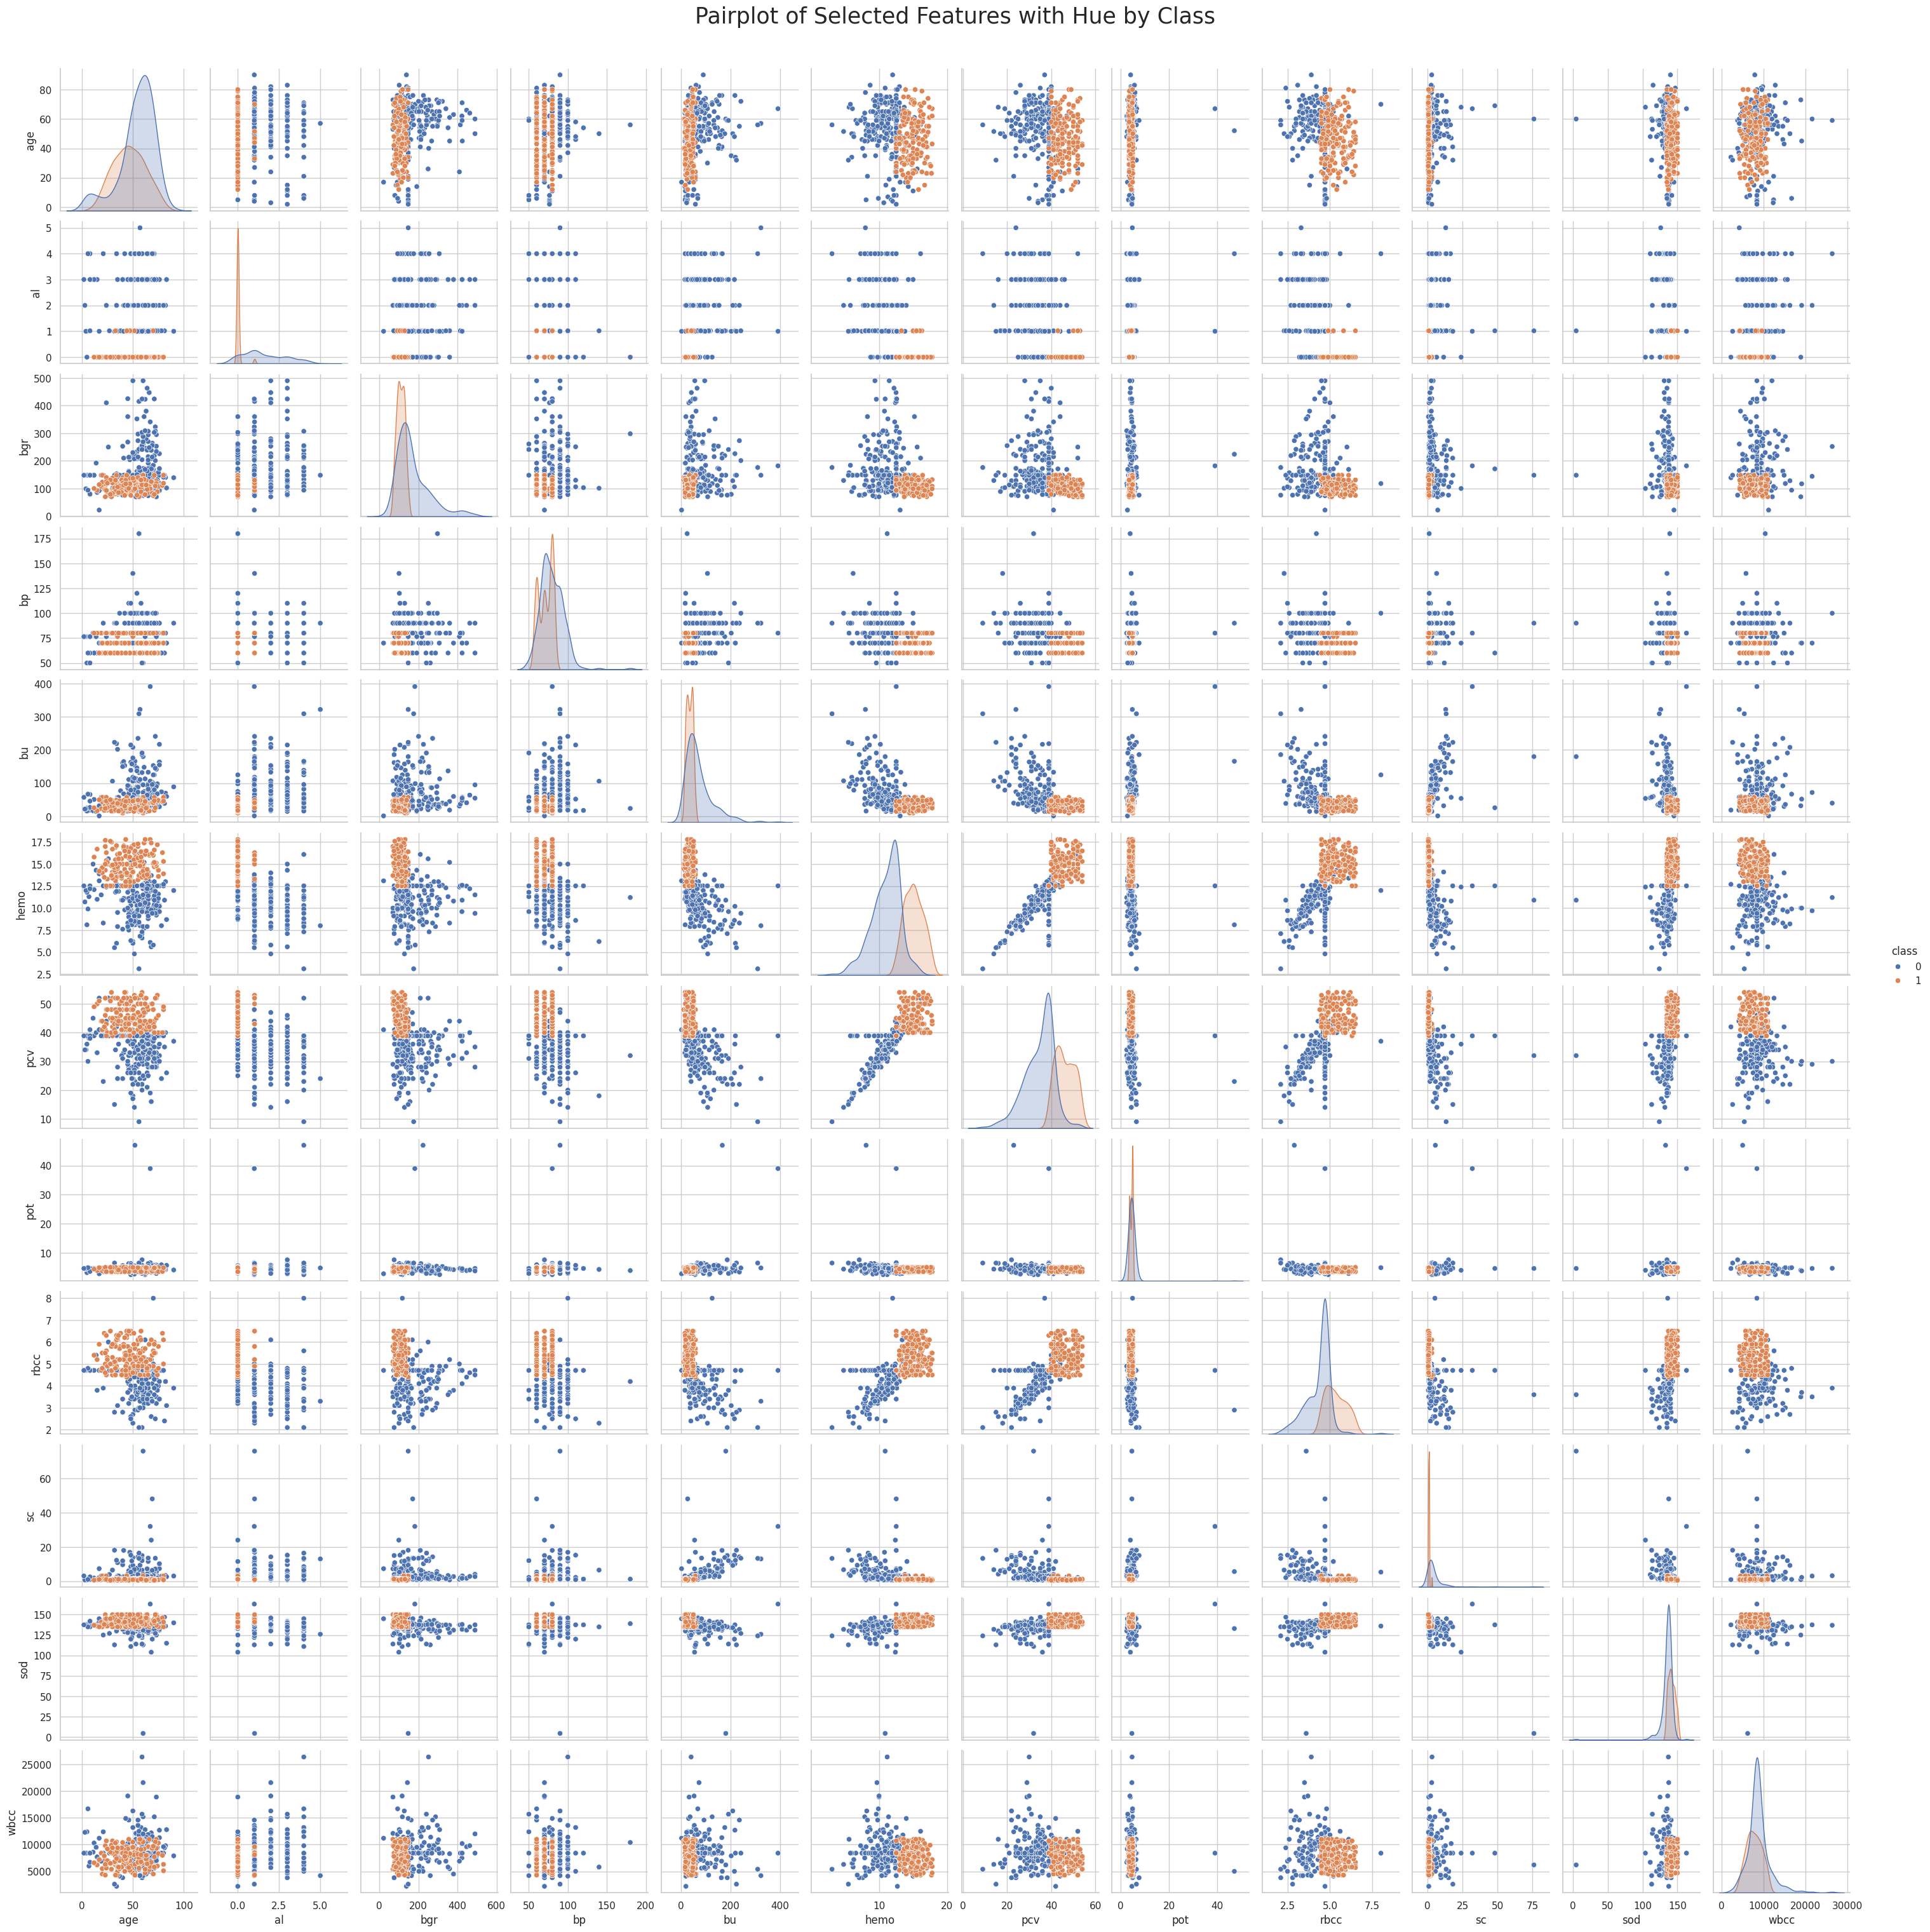

In [ ]:
# the features to include in the pairplot
selected_features = ['age', 'al', 'bgr', 'bp', 'bu', 'hemo', 'pcv', 'pot', 'rbcc', 'sc', 'sod', 'wbcc']

# Pairplot to visualize the relationships between selected features
pairplot = sns.pairplot(CKD_data, hue='class', vars=selected_features)
pairplot.fig.suptitle('Pairplot of Selected Features with Hue by Class', size=25, y=1.02)

plt.show()

In [ ]:
X_input = CKD_data.drop('class', axis=1)  # Features
y_target = CKD_data['class']  # Target


In [ ]:
y_target

,class
0,0
1,0
2,0
3,0
4,0
...,...
395,1
396,1
397,1
398,1


In [ ]:
X_input

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,hemo,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane
0,48.0,80.0,1.020,1.0,0.0,2,1,0,0,121.000000,...,15.4,44.0,7800.0,5.200000,1,2,0,0,0,0
1,7.0,50.0,1.020,4.0,0.0,2,1,0,0,148.036517,...,11.3,38.0,6000.0,4.707435,0,1,0,0,0,0
2,62.0,80.0,1.010,2.0,3.0,1,1,0,0,423.000000,...,9.6,31.0,7500.0,4.707435,0,2,0,1,0,1
3,48.0,70.0,1.005,4.0,0.0,1,0,1,0,117.000000,...,11.2,32.0,6700.0,3.900000,1,1,0,1,1,1
4,51.0,80.0,1.010,2.0,0.0,1,1,0,0,106.000000,...,11.6,35.0,7300.0,4.600000,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,55.0,80.0,1.020,0.0,0.0,1,1,0,0,140.000000,...,15.7,47.0,6700.0,4.900000,0,1,0,0,0,0
396,42.0,70.0,1.025,0.0,0.0,1,1,0,0,75.000000,...,16.5,54.0,7800.0,6.200000,0,1,0,0,0,0
397,12.0,80.0,1.020,0.0,0.0,1,1,0,0,100.000000,...,15.8,49.0,6600.0,5.400000,0,1,0,0,0,0
398,17.0,60.0,1.025,0.0,0.0,1,1,0,0,114.000000,...,14.2,51.0,7200.0,5.900000,0,1,0,0,0,0


In [ ]:
y_target

,class
0,0
1,0
2,0
3,0
4,0
...,...
395,1
396,1
397,1
398,1


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_input, y_target, test_size=0.2, random_state=42, stratify=y_target)


In [ ]:
X_train

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,hemo,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane
380,59.0,60.0,1.020,0.0,0.000000,1,1,0,0,113.000000,...,15.300000,54.000000,6500.000000,4.900000,0,1,0,0,0,0
56,76.0,70.0,1.015,3.0,4.000000,1,0,1,0,148.036517,...,10.200000,30.000000,11300.000000,3.400000,1,2,1,1,1,0
126,70.0,90.0,1.015,0.0,0.000000,2,1,0,0,144.000000,...,12.000000,37.000000,8200.000000,4.500000,1,2,0,1,1,0
371,28.0,60.0,1.025,0.0,0.000000,1,1,0,0,79.000000,...,17.600000,51.000000,6500.000000,5.000000,0,1,0,0,0,0
333,23.0,80.0,1.020,0.0,0.000000,1,1,0,0,99.000000,...,17.700000,46.000000,4300.000000,5.500000,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154,56.0,90.0,1.005,4.0,3.000000,0,0,0,0,242.000000,...,8.400000,26.000000,8406.122449,3.000000,1,2,0,1,1,1
274,19.0,80.0,1.020,0.0,0.000000,1,1,0,0,107.000000,...,14.400000,44.000000,8406.122449,4.707435,0,1,0,0,0,0
192,46.0,110.0,1.015,0.0,0.000000,2,1,0,0,130.000000,...,12.526437,38.884498,8406.122449,4.707435,0,1,0,0,0,0
85,70.0,70.0,1.015,2.0,0.450142,2,2,0,0,148.036517,...,9.900000,38.884498,8406.122449,4.707435,0,2,0,1,1,0


In [ ]:
X_test

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,hemo,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane
160,81.0,60.0,1.017408,1.016949,0.450142,2,2,0,0,148.0,...,10.9,35.0,9400.0,2.400000,1,2,1,1,1,0
20,61.0,80.0,1.015000,2.000000,0.000000,0,0,0,0,173.0,...,7.7,24.0,9200.0,3.200000,1,2,1,1,1,1
392,57.0,80.0,1.020000,0.000000,0.000000,1,1,0,0,133.0,...,14.8,46.0,6600.0,5.500000,0,1,0,0,0,0
303,55.0,70.0,1.020000,0.000000,0.000000,1,1,0,0,107.0,...,17.0,50.0,6700.0,6.100000,0,1,0,0,0,0
339,25.0,70.0,1.020000,0.000000,0.000000,1,1,0,0,88.0,...,13.3,48.0,7000.0,4.900000,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,45.0,70.0,1.010000,2.000000,0.000000,2,1,0,0,113.0,...,7.9,26.0,5700.0,4.707435,0,1,1,0,0,1
369,75.0,70.0,1.020000,0.000000,0.000000,1,1,0,0,107.0,...,13.6,46.0,10300.0,4.800000,0,1,0,0,0,0
258,42.0,80.0,1.020000,0.000000,0.000000,1,1,0,0,98.0,...,13.9,44.0,8400.0,5.500000,0,1,0,0,0,0
157,62.0,70.0,1.025000,3.000000,0.000000,1,0,0,0,122.0,...,12.6,39.0,7900.0,3.900000,1,2,0,0,0,0


In [ ]:
y_test.head()

,class
160,0
20,0
392,1
303,1
339,1


##  SMOTE for handling data imbalance


In [ ]:
print("Class distribution before SMOTE:")
print(y_train.value_counts())

Class distribution before SMOTE:
class
0    200
1    120
Name: count, dtype: int64


In [ ]:
from imblearn.over_sampling import SMOTE

# Initialize SMOTE with k_neighbors=1
smote = SMOTE(random_state=42, k_neighbors=1)

# Apply SMOTE
X_train, y_train = smote.fit_resample(X_train, y_train)

# Check the class distribution after SMOTE
print("Class distribution after SMOTE:", y_train.value_counts())


Class distribution after SMOTE: class
1    200
0    200
Name: count, dtype: int64


# Feature Scaling

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


# Model Implementation
## DecisionTreeClassifier

In [ ]:
# Initialize a shallow decision tree
dt_model = DecisionTreeClassifier(max_depth=3, random_state=42)

# Train the model
dt_model.fit(X_train, y_train)

# Predict on the test set
y_pred_dt = dt_model.predict(X_test)
y_proba_dt = dt_model.predict_proba(X_test)[:, 1]

# Evaluate the model
print("\nClassification Report:")
print(classification_report(y_test, y_pred_dt))

# AUC-ROC score
roc_auc_dt = roc_auc_score(y_test, y_proba_dt)
print("AUC-ROC Score:", roc_auc_dt)
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_dt))



Classification Report:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95        50
           1       1.00      0.83      0.91        30

    accuracy                           0.94        80
   macro avg       0.95      0.92      0.93        80
weighted avg       0.94      0.94      0.94        80

AUC-ROC Score: 0.9053333333333333

Confusion Matrix:
[[50  0]
 [ 5 25]]


In [ ]:
# Calculate and print accuracy
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print(f"DecisionTreeClassifier Accuracy: {accuracy_dt * 100:.2f}%")

DecisionTreeClassifier Accuracy: 93.75%


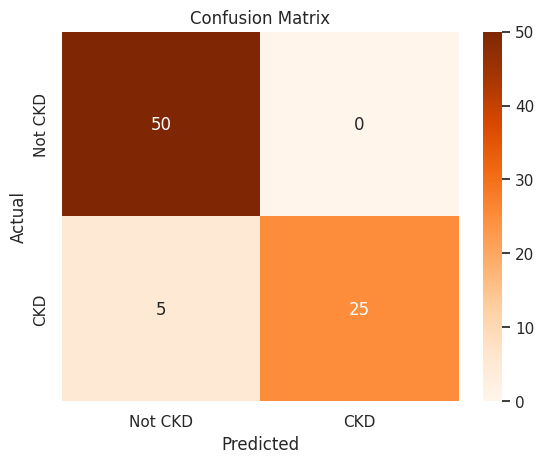

In [ ]:
# Confusion matrix
cm_dt = confusion_matrix(y_test, y_pred_dt)
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Oranges', xticklabels=['Not CKD', 'CKD'], yticklabels=['Not CKD', 'CKD'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

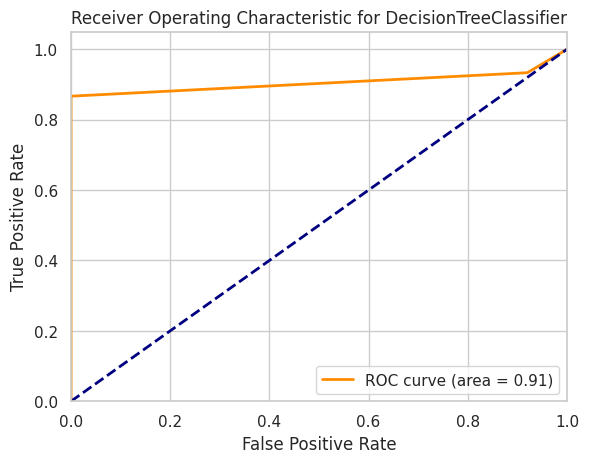

In [ ]:
# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba_dt)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for DecisionTreeClassifier')
plt.legend(loc="lower right")
plt.show()

## KNeighborsClassification Model

In [ ]:
# Initialize k-NN with k=3
knn_model = KNeighborsClassifier(n_neighbors=3)

# Train the model
knn_model.fit(X_train, y_train)

# Predict on the test set
y_pred_knn = knn_model.predict(X_test)
y_proba_knn = knn_model.predict_proba(X_test)[:, 1]

# Evaluate the model
print("\nClassification Report:")
print(classification_report(y_test, y_pred_knn))

# AUC-ROC score
roc_auc_knn = roc_auc_score(y_test, y_proba_knn)
print("AUC-ROC Score:", roc_auc_knn)

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_knn))



Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97        50
           1       0.97      0.93      0.95        30

    accuracy                           0.96        80
   macro avg       0.96      0.96      0.96        80
weighted avg       0.96      0.96      0.96        80

AUC-ROC Score: 0.956

Confusion Matrix:
[[49  1]
 [ 2 28]]


In [ ]:
# Calculate and print accuracy
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(f"KNeighborsClassifier Accuracy: {accuracy_knn * 100:.2f}%")

KNeighborsClassifier Accuracy: 96.25%


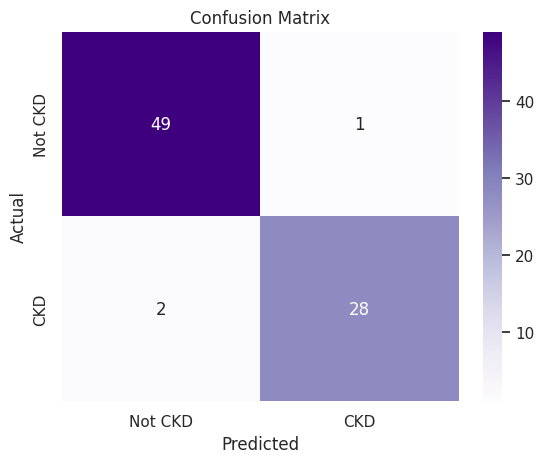

In [ ]:
# Confusion matrix
cm_knn = confusion_matrix(y_test, y_pred_knn)
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Purples', xticklabels=['Not CKD', 'CKD'], yticklabels=['Not CKD', 'CKD'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

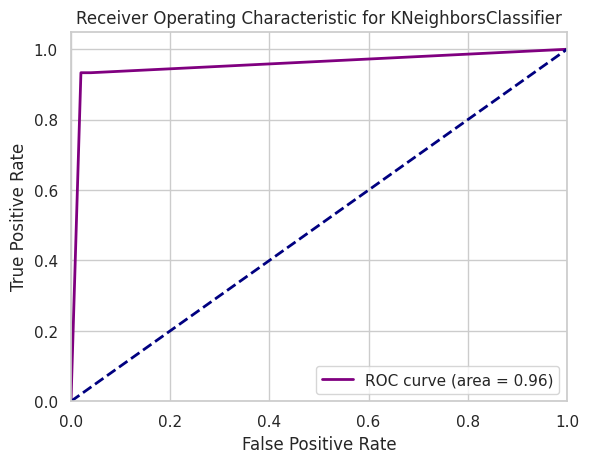

In [ ]:
# Plot ROC Curve
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_test, y_proba_knn)
roc_auc_knn = auc(fpr_knn, tpr_knn)

# Plot the ROC Curve
plt.figure()
plt.plot(fpr_knn, tpr_knn, color='purple', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_knn)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for KNeighborsClassifier')
plt.legend(loc="lower right")
plt.show()


## XGBoost Classifier Model

In [ ]:
# Initialize an XGBoost classifier
xgb_model = XGBClassifier(max_depth=3, n_estimators=100, learning_rate=0.01, random_state=42)

# Train the model
xgb_model.fit(X_train, y_train)

# Predict on the test set
y_pred_xgb = xgb_model.predict(X_test)
y_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

# Evaluate the model
print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb))

# AUC-ROC score
roc_auc_xgb = roc_auc_score(y_test, y_proba_xgb)
print("AUC-ROC Score:", roc_auc_xgb)
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb))



Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.98      0.96        50
           1       0.96      0.90      0.93        30

    accuracy                           0.95        80
   macro avg       0.95      0.94      0.95        80
weighted avg       0.95      0.95      0.95        80

AUC-ROC Score: 0.9776666666666668

Confusion Matrix:
[[49  1]
 [ 3 27]]


In [ ]:
# Calculate and print accuracy
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print(f"XGBoost Classifier Accuracy: {accuracy_xgb * 100:.2f}%")

XGBoost Classifier Accuracy: 95.00%


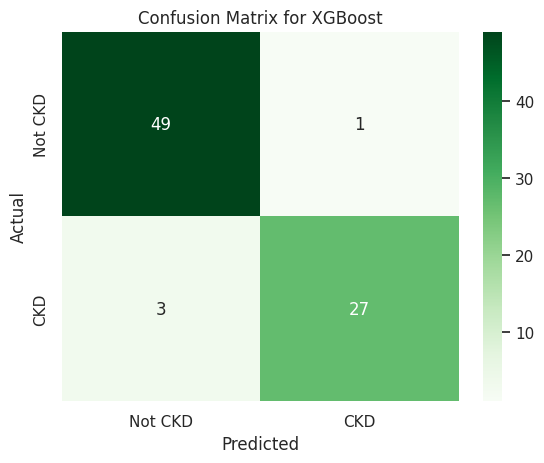

In [ ]:
# Confusion matrix visualization
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Greens', xticklabels=['Not CKD', 'CKD'], yticklabels=['Not CKD', 'CKD'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix for XGBoost')
plt.show()

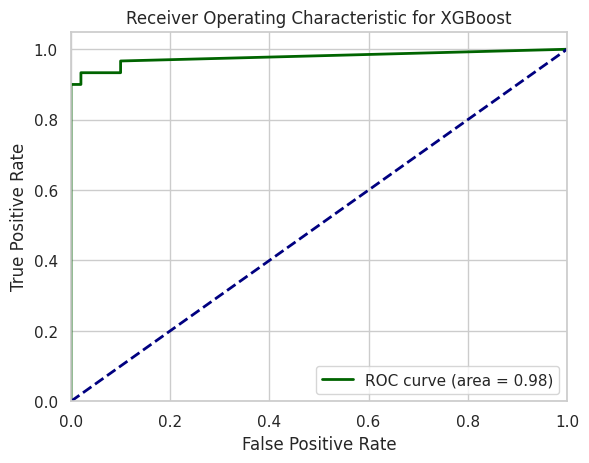

In [ ]:
# Plot ROC Curve
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, y_proba_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

# Plot the ROC Curve
plt.figure()
plt.plot(fpr_xgb, tpr_xgb, color='darkgreen', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_xgb)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for XGBoost')
plt.legend(loc="lower right")
plt.show()


##  Random Forest Classifier Model

In [ ]:
# Initialize a Random Forest classifier
rf_model = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred_rf = rf_model.predict(X_test)
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]

# Evaluate the model
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))

# AUC-ROC score
roc_auc_rf = roc_auc_score(y_test, y_proba_rf)
print("AUC-ROC Score:", roc_auc_rf)
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))


Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        50
           1       1.00      0.93      0.97        30

    accuracy                           0.97        80
   macro avg       0.98      0.97      0.97        80
weighted avg       0.98      0.97      0.97        80

AUC-ROC Score: 0.9986666666666667

Confusion Matrix:
[[50  0]
 [ 2 28]]


In [ ]:
# Calculate and print accuracy
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Classifier Accuracy: {accuracy_rf * 100:.2f}%")

Random Forest Classifier Accuracy: 97.50%


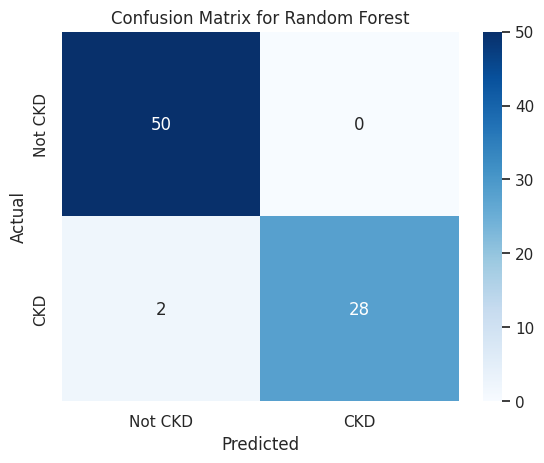

In [ ]:
# Confusion matrix visualization
cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', xticklabels=['Not CKD', 'CKD'], yticklabels=['Not CKD', 'CKD'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix for Random Forest')
plt.show()

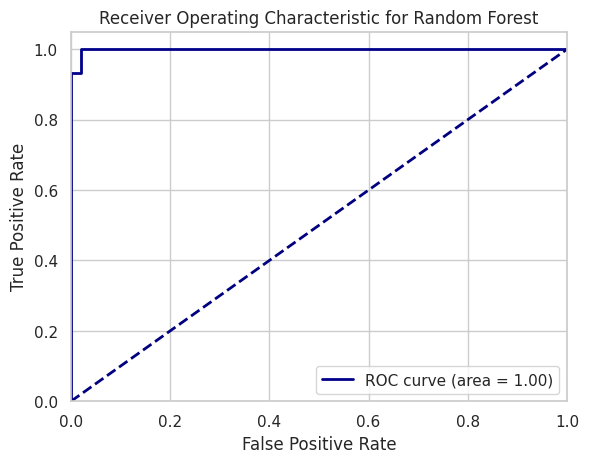

In [ ]:
# Plot ROC Curve
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_proba_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Plot the ROC Curve
plt.figure()
plt.plot(fpr_rf, tpr_rf, color='darkblue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_rf)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Random Forest')
plt.legend(loc="lower right")
plt.show()


## Ensemble Model with Meta Learner

In [ ]:
# Define base models
base_models = [
    ('decision_tree', DecisionTreeClassifier(max_depth=5, random_state=42)),
    ('random_forest', RandomForestClassifier(n_estimators=100, max_depth=3, random_state=42)),
    ('xgboost', XGBClassifier(max_depth=5, n_estimators=100, learning_rate=0.2, random_state=42))
]

# Define meta-learner model with enhanced parameters
meta_learner = LogisticRegression(C=0.1, solver='liblinear', max_iter=200, random_state=42)

# Create the stacking ensemble model
stack_model = StackingClassifier(estimators=base_models, final_estimator=meta_learner, cv=5)

# Train the stacking model
stack_model.fit(X_train, y_train)

# Predict on the test set
y_pred_stack = stack_model.predict(X_test)
y_proba_stack = stack_model.predict_proba(X_test)[:, 1]

# Evaluate the model
print("\nClassification Report:")
print(classification_report(y_test, y_pred_stack))

# AUC-ROC score
roc_auc_stack = roc_auc_score(y_test, y_proba_stack)
print("AUC-ROC Score:", roc_auc_stack)
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_stack))


Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        50
           1       1.00      0.97      0.98        30

    accuracy                           0.99        80
   macro avg       0.99      0.98      0.99        80
weighted avg       0.99      0.99      0.99        80

AUC-ROC Score: 1.0

Confusion Matrix:
[[50  0]
 [ 1 29]]


In [ ]:
# Calculate and print accuracy
accuracy_stack = accuracy_score(y_test, y_pred_stack)
print(f"Stacking Classifier Accuracy: {accuracy_stack * 100:.2f}%")

Stacking Classifier Accuracy: 98.75%


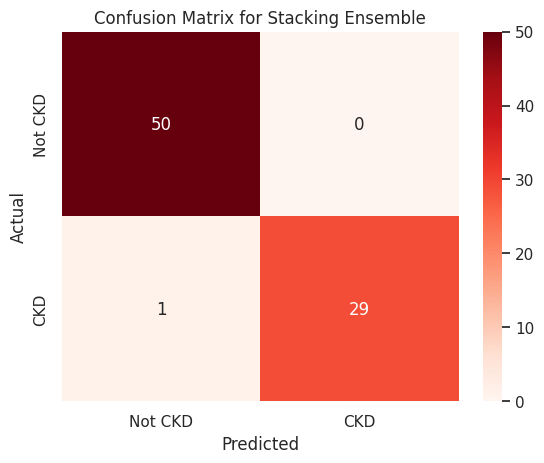

In [ ]:
# Confusion matrix visualization
cm_stack = confusion_matrix(y_test, y_pred_stack)
sns.heatmap(cm_stack, annot=True, fmt='d', cmap='Reds', xticklabels=['Not CKD', 'CKD'], yticklabels=['Not CKD', 'CKD'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix for Stacking Ensemble')
plt.show()

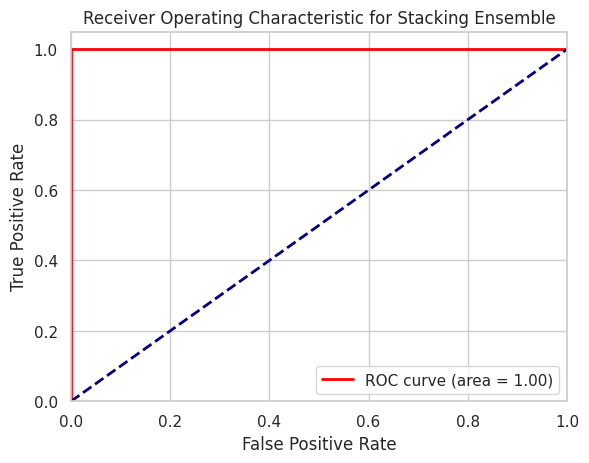

In [ ]:
# Plot ROC Curve
fpr_stack, tpr_stack, thresholds_stack = roc_curve(y_test, y_proba_stack)
roc_auc_stack = auc(fpr_stack, tpr_stack)

# Plot the ROC Curve
plt.figure()
plt.plot(fpr_stack, tpr_stack, color='red', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_stack)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Stacking Ensemble')
plt.legend(loc="lower right")
plt.show()


# Model Implementation
## Comparison of five Models

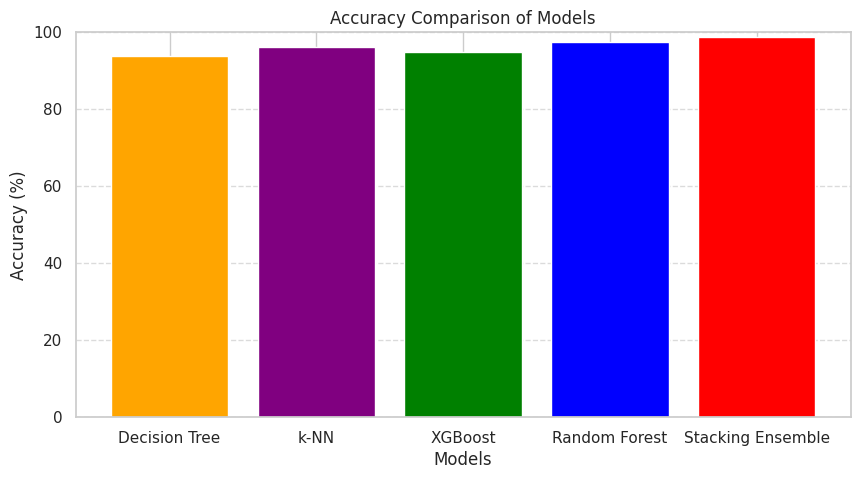

In [ ]:
# Accuracy values for each model
model_names = ['Decision Tree', 'k-NN', 'XGBoost', 'Random Forest', 'Stacking Ensemble']
accuracies = [
    accuracy_dt * 100,    # Accuracy from Decision Tree
    accuracy_knn * 100,   # Accuracy from k-NN
    accuracy_xgb * 100,   # Accuracy from XGBoost
    accuracy_rf * 100,    # Accuracy from Random Forest
    accuracy_stack * 100  # Accuracy from Stacking Ensemble
]

# Plot accuracy comparison
plt.figure(figsize=(10, 5))
plt.bar(model_names, accuracies, color=['orange', 'purple', 'green', 'blue', 'red'])
plt.xlabel('Models')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Comparison of Models')
plt.ylim(0, 100)  # Ensure y-axis covers 0-100%
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


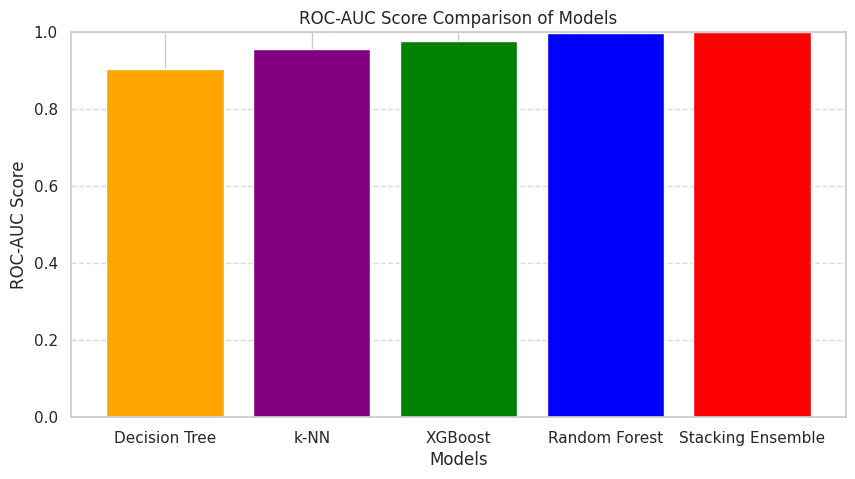

In [ ]:
model_names = ['Decision Tree', 'k-NN', 'XGBoost', 'Random Forest', 'Stacking Ensemble']
roc_auc_scores = [
    roc_auc_dt,   # ROC-AUC for Decision Tree
    roc_auc_knn,  # ROC-AUC for k-NN
    roc_auc_xgb,  # ROC-AUC for XGBoost
    roc_auc_rf,   # ROC-AUC for Random Forest
    roc_auc_stack # ROC-AUC for Stacking Ensemble
]

# Plot ROC-AUC comparison
plt.figure(figsize=(10, 5))
plt.bar(model_names, roc_auc_scores, color=['orange', 'purple', 'green', 'blue', 'red'])
plt.xlabel('Models')
plt.ylabel('ROC-AUC Score')
plt.title('ROC-AUC Score Comparison of Models')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


               Model  Accuracy (%)
0      Decision Tree         93.75
1               k-NN         96.25
2            XGBoost         95.00
3      Random Forest         97.50
4  Stacking Ensemble         98.75


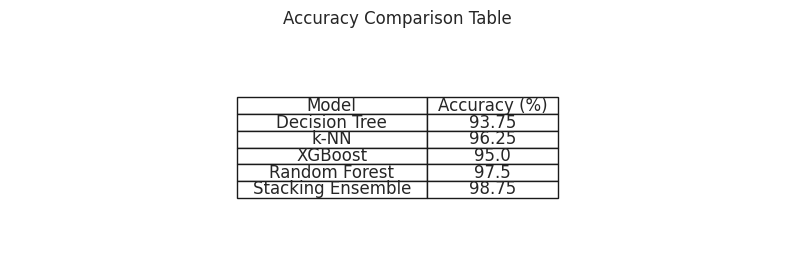

In [ ]:
model_names = ['Decision Tree', 'k-NN', 'XGBoost', 'Random Forest', 'Stacking Ensemble']
accuracies = [accuracy_dt * 100, accuracy_knn * 100, accuracy_xgb * 100, accuracy_rf * 100, accuracy_stack * 100]

# Create a DataFrame for comparison
comparison_table = pd.DataFrame({
    'Model': model_names,
    'Accuracy (%)': accuracies
})

# Display the table
print(comparison_table)


plt.figure(figsize=(10, 3))
plt.axis('tight')
plt.axis('off')
table = plt.table(cellText=comparison_table.values,
                  colLabels=comparison_table.columns,
                  loc='center',
                  cellLoc='center')
table.auto_set_font_size(False)
table.set_fontsize(12)
table.auto_set_column_width(col=list(range(len(comparison_table.columns))))
plt.title("Accuracy Comparison Table")
plt.show()


Comparison Table:
               Model  Accuracy (%)   AUC-ROC
0      Decision Tree         93.75  0.905333
1               k-NN         96.25  0.956000
2            XGBoost         95.00  0.977667
3      Random Forest         97.50  0.998667
4  Stacking Ensemble         98.75  1.000000


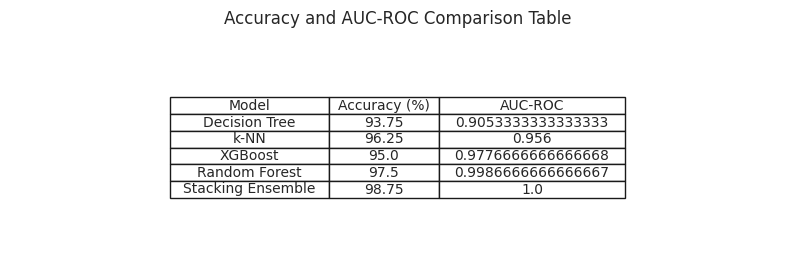

In [ ]:
model_names = ['Decision Tree', 'k-NN', 'XGBoost', 'Random Forest', 'Stacking Ensemble']
accuracies = [accuracy_dt * 100, accuracy_knn * 100, accuracy_xgb * 100, accuracy_rf * 100, accuracy_stack * 100]  # Accuracy values in percentages
roc_aucs = [roc_auc_dt, roc_auc_knn, roc_auc_xgb, roc_auc_rf, roc_auc_stack]       # AUC-ROC scores

# Create a DataFrame for comparison
comparison_table = pd.DataFrame({
    'Model': model_names,
    'Accuracy (%)': accuracies,
    'AUC-ROC': roc_aucs
})

# Highlight the table
def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: lightgreen' if v else '' for v in is_max]

# Style the DataFrame
styled_table = comparison_table.style.apply(highlight_max, subset=['Accuracy (%)', 'AUC-ROC']).set_table_styles(
    [{'selector': 'thead th', 'props': [('background-color', 'lightblue'), ('color', 'black'), ('font-weight', 'bold')]}]
)

# Display the styled table in the notebook or script
print("Comparison Table:")
print(comparison_table)


def save_styled_table_as_image(df_styler, filename):
    dfi.export(df_styler, filename)


plt.figure(figsize=(10, 3))  # Adjusted size for better display
plt.axis('tight')
plt.axis('off')
table = plt.table(cellText=comparison_table.values,
                  colLabels=comparison_table.columns,
                  loc='center',
                  cellLoc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.auto_set_column_width(col=list(range(len(comparison_table.columns))))
plt.title("Accuracy and AUC-ROC Comparison Table")
plt.show()


In [ ]:
import plotly.graph_objects as go

# model names and metrics
model_names = ['Decision Tree', 'k-NN', 'XGBoost', 'Random Forest', 'Stacking Ensemble']
accuracies = [accuracy_dt * 100, accuracy_knn * 100, accuracy_xgb * 100, accuracy_rf * 100, accuracy_stack * 100]  # Accuracy values in percentages
roc_aucs = [roc_auc_dt, roc_auc_knn, roc_auc_xgb, roc_auc_rf, roc_auc_stack]  # AUC-ROC scores

# Create a Plotly Table
fig = go.Figure(data=[go.Table(
    header=dict(
        values=["<b>Model Names</b>", "<b>Accuracy (%)</b>", "<b>AUC-ROC</b>"],
        fill_color="#264653",
        font=dict(color="white", size=16),
        align="center",
        height=40,
    ),
    cells=dict(
        values=[model_names, accuracies, roc_aucs],
        fill_color=[["#f4f4f9"] * len(model_names),
                   ["#FFD700"] * len(accuracies),
                   ["#ffcccc"] * len(roc_aucs)],
        font=dict(color="black", size=14),
        align="center",
        height=30,
    )
)])

# Customize layout
fig.update_layout(
    title="Model Performance Comparison",
    title_font=dict(size=22, family='Arial', color='#264653'),
    margin=dict(l=20, r=20, t=50, b=20),
    paper_bgcolor='white',
    plot_bgcolor='white'
)

# Show the table
fig.show()
